In [1]:
import numpy as np
import xarray as xr
import healpy as hp

import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt
import cmocean as cm

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature

import pandas as pd
import geopandas as gpd
import osmnx as ox
import rioxarray
from rasterio import features

from shapely.geometry import Point, Polygon, MultiPolygon

from easygems.healpix import attach_coords

In [3]:
zoom = '10'
# file = '/scratch/nf33/Healpix_data/UM/data.healpix.PT3H.z' + zoom + '.zarr'

# direc = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z" + zoom +".zarr" # UM PT1H is hourly data
direc = "/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z11_atm.zarr" #PT1H is hourly data
ds = xr.open_zarr(direc)
ds = ds.pipe(egh.attach_coords)
ds

<xarray.Dataset> Size: 14TB
Dimensions:  (cell: 50331648, time: 10200)
Coordinates:
  * time     (time) datetime64[ns] 82kB 2020-01-01T01:00:00 ... 2021-03-01
    crs      int64 8B 0
  * cell     (cell) int64 403MB 0 1 2 3 ... 50331644 50331645 50331646 50331647
    lat      (cell) float64 403MB 0.01865 0.0373 0.0373 ... -0.0373 -0.01865
    lon      (cell) float64 403MB 45.0 45.02 44.98 45.0 ... 315.0 315.0 315.0
Data variables:
    orog     (cell) float32 201MB dask.array<chunksize=(50331648,), meta=np.ndarray>
    pr       (time, cell) float32 2TB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    psl      (time, cell) float32 2TB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    rlut     (time, cell) float32 2TB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    rsut     (time, cell) float32 2TB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    sftgif   (cell) float32 201MB dask.array<chunksize=(50331648,), meta=np.ndarray>
    sftlf    (cell) float32 201MB dask.array<chunksize=(50331648,), meta=np.ndarray>
    ts       (time, cell) float32 2TB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    uas      (time, cell) float32 2TB dask.array<chunksize=(4, 262144), meta=np.ndarray>
    vas      (time, cell) float32 2TB dask.array<chunksize=(4, 262144), meta=np.ndarray>
Attributes:
    hiopy::parent:  PT1H_point_z12_atm

In [4]:
# ds = ds.sel(time=slice('2020-01-20T13','2020-02-20T13'))

In [5]:
%%time
## Masking for land exclude ocean

# ds_tas = ds.tas.where(ds.orog > 0)

ds_tas = ds.ts.where(ds.sftlf>0)

CPU times: user 54.1 ms, sys: 7.62 ms, total: 61.7 ms
Wall time: 73.5 ms


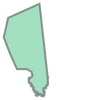

In [6]:
## Cities

cities = [
    "Jakarta"
]
gdf = ox.geocode_to_gdf(cities)

gdf.geometry.iloc[0]

In [7]:
geo_centroid = [gdf.geometry.centroid.x.iloc[0], gdf.geometry.centroid.y.iloc[0]]

boundary_coords = np.array(gdf.geometry.iloc[0].exterior.coords)

/jobfs/140911530.gadi-pbs/ipykernel_2288939/648222507.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_centroid = [gdf.geometry.centroid.x.iloc[0], gdf.geometry.centroid.y.iloc[0]]


In [8]:
## making circle around city

distances = np.sqrt((geo_centroid[0] - boundary_coords[:, 0])**2 + (geo_centroid[1] - boundary_coords[:, 1])**2)
radius = distances.max()

theta = np.linspace(0, 2 * np.pi, 150)

x = radius * np.cos(theta) + geo_centroid[0]
y = radius * np.sin(theta) + geo_centroid[1]

In [10]:
ds_tas_clip = ds_tas.where((ds.lon > boundary_coords[:, 0].min()-0.5) & (ds.lon < boundary_coords[:, 0].max()+0.5) \
                         & (ds.lat > boundary_coords[:, 1].min()-0.5) & (ds.lat < boundary_coords[:, 1].max()+0.5), drop=True )

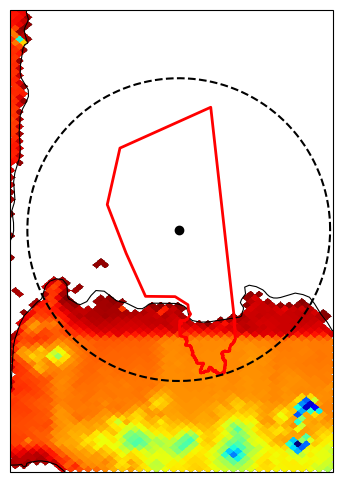

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([boundary_coords[:, 0].min()-0.5, boundary_coords[:, 0].max()+0.5,
               boundary_coords[:, 1].min()-0.5, boundary_coords[:, 1].max()+0.5], crs=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
ax.add_feature(cf.OCEAN, facecolor='lightblue')

artist = egh.healpix_show((ds_ts_clip-273.15).mean('time'), cmap='coolwarm', vmin=23, vmax=31)
# artist = egh.healpix_show((ds_um_.ts - ds_icon_.ts), cmap='coolwarm', vmin=-5, vmax=5)
fig.colorbar(artist, label=r"Land Surface Temperature [$^{\circ}$C]", orientation="vertical", pad=0.05)
# fig.colorbar(artist, label=r"$\Delta$ T [$^{\circ}$C]", orientation="vertical", pad=0.05)

city_boundary = ShapelyFeature(gdf["geometry"][0], ccrs.PlateCarree(), edgecolor='k',
                               facecolor='none', linestyle='-', linewidth=2)
ax.add_feature(city_boundary)

ax.plot(geo_centroid[0], geo_centroid[1], marker='o', c='k')
ax.plot(x, y, '--', c='k')

# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_um_jkt.png', bbox_inches='tight', dpi=200, )
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_icon_jkt.png', bbox_inches='tight', dpi=200, )
# plt.savefig('/g/data/hh5/tmp/ab2462/heckathon2025/ts_mean_diff_um_icon_jkt.png', bbox_inches='tight', dpi=200, )

In [ ]:
# ds_ts_clip.mean('time').to_netcdf('/g/data/hh5/tmp/ab2462/heckathon2025/Ts_tmean_icon_jakarta.nc')
# ds_ts_clip.mean('time').to_netcdf('/g/data/hh5/tmp/ab2462/heckathon2025/Ts_tmean_um_jakarta.nc')

In [ ]:
# ds_um_ = xr.open_dataset('/g/data/hh5/tmp/ab2462/heckathon2025/Ts_tmean_um_jakarta.nc')
# ds_icon_ = xr.open_dataset('/g/data/hh5/tmp/ab2462/heckathon2025/Ts_tmean_icon_jakarta.nc')

In [12]:
### masking city data

from shapely.geometry import Point, Polygon, MultiPolygon

lat = ds_tas_clip.lat
lon = ds_tas_clip.lon

cell_points = gpd.GeoSeries([Point(lon[i].item(), lat[i].item()) for i in range(len(lat))], crs="EPSG:4326")

### circular region:
circle_polygon = Polygon([ (radius * np.cos(angle) + geo_centroid[0],
                            radius * np.sin(angle) + geo_centroid[1] )
                            for angle in np.linspace(0, 2 * np.pi, 150)]) 

region_mask = cell_points.within(circle_polygon)
cell_mask_region = xr.DataArray(region_mask.values, dims=["cell"])

### city:
city_polygon = Polygon([ (boundary_coords[i, 0], boundary_coords[i, 1]) for i in range(boundary_coords.shape[0])])

city_mask = cell_points.within(city_polygon)
cell_mask_city = xr.DataArray(city_mask.values, dims=["cell"])



ts_region = ds_tas_clip.where(cell_mask_region)  # masking cicular region

ts_city = ts_region.where(cell_mask_city)  # masking city
ts_outside = ts_region.where(~cell_mask_city)  # masking outside city

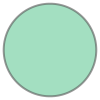

In [106]:
circle_polygon

In [99]:
ts_city

<xarray.DataArray 'tas' (time: 10489, cell: 1197)> Size: 50MB
dask.array<where, shape=(10489, 1197), dtype=float32, chunksize=(1, 1197), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
    crs      int64 8B 0
  * cell     (cell) int64 10kB 5551851 5551852 5551853 ... 5652516 5652520
    lat      (cell) float64 10kB -6.843 -6.843 -6.805 ... -4.518 -4.518 -4.518
    lon      (cell) float64 10kB 107.3 107.4 107.4 107.4 ... 106.7 106.8 106.6
Attributes:
    STASH:          [1, 3, 236]
    UM_name:        air_temperature
    grid_mapping:   healpix_nested
    healpix_zoom:   10
    long_name:      air_temperature
    source:         Data from Met Office Unified Model
    standard_name:  air_temperature
    um_version:     13.5
    units:          K

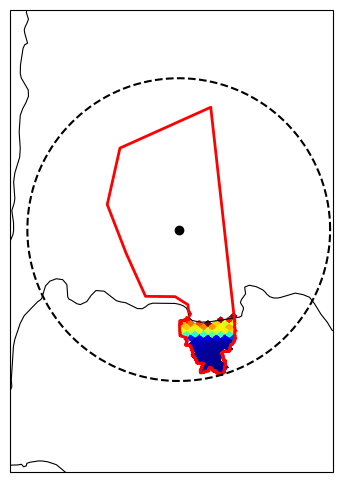

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([boundary_coords[:, 0].min()-0.5, boundary_coords[:, 0].max()+0.5,
               boundary_coords[:, 1].min()-0.5, boundary_coords[:, 1].max()+0.5], crs=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

egh.healpix_show(ts_city.isel(time=0), ax=ax, cmap='jet')

city_boundary = ShapelyFeature(gdf["geometry"][0], ccrs.PlateCarree(), edgecolor='r',
                               facecolor='none', linestyle='-', linewidth=2)
ax.add_feature(city_boundary)

ax.plot(geo_centroid[0], geo_centroid[1], marker='o', c='k')
ax.plot(x, y, '--', c='k')

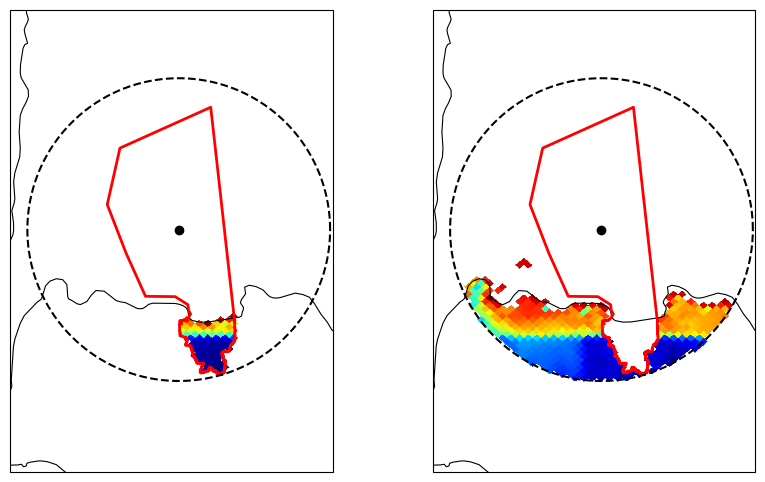

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

city_boundary = ShapelyFeature(gdf["geometry"][0], ccrs.PlateCarree(), edgecolor='r',
                               facecolor='none', linestyle='-', linewidth=2)

for ax_ in ax.flatten():
    ax_.set_extent([boundary_coords[:, 0].min()-0.5, boundary_coords[:, 0].max()+0.5,
                   boundary_coords[:, 1].min()-0.5, boundary_coords[:, 1].max()+0.5], crs=ccrs.PlateCarree())
    ax_.add_feature(cf.COASTLINE, linewidth=0.8)
    ax_.add_feature(cf.BORDERS, linewidth=0.4)
    
    ax_.add_feature(city_boundary)
    
    ax_.plot(geo_centroid[0], geo_centroid[1], marker='o', c='k')
    ax_.plot(x, y, '--', c='k')

egh.healpix_show(ts_city.isel(time=0), ax=ax[0], cmap='jet')

egh.healpix_show(ts_outside.isel(time=0), ax=ax[1], cmap='jet')